In [21]:
import numpy as np

def ltvlqr(states,A,B,Q_k,R_k,Q_T):
    # This function (linear time varying linear quadratic regularizer)
    # schedules feedback gains by using the discrete algebraic riccati equation
    
    # Get the number of timesteps, dimension of states and dimension of inputs
    n_timesteps = np.shape(states)[0]
    n_states = np.shape(states)[1]
    n_inputs =1
    
    K_feedback = np.zeros((n_timesteps,1,n_states))
    # Boundary condition
    P_k = Q_T
    for ii in reversed(range(0, 100)):# Run backwards in time
        # Get the current state and input
        current_state = states[ii,:].flatten()
        #current_input = inputs[ii,:].flatten()
        
        # Get the linearization about the state and input pair
        A_k = A[ii]
        B_k = B[ii].reshape(4,1)
        # Calculate the feedback gain and store it
        #print(R_k.shape)
        #print(B_k.shape)
        #print(P_k.shape)
        #print(A_k.shape)
        K_k = -np.linalg.inv(R_k+B_k.T@P_k@B_k)@B_k.T@P_k@A_k
        K_feedback[ii,:,:] = K_k
        # update for P
        P_k = Q_k+A_k.T@P_k@A_k-A_k.T@P_k@B_k@np.linalg.inv(R_k+B_k.T@P_k@B_k)@B_k.T@P_k@A_k
    return K_feedback

In [22]:
import torch
A=torch.load('/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/latent_2/control_data_local.pt')
A=A[:100]
states=[]
A_mat=[]
B_mat=[]
for i in range(len(A)):
    states.append(A[i][0].detach().numpy()[:4])
    A_mat.append(A[i][1].detach().numpy()[:4,:4])
    B_mat.append(A[i][2].detach().numpy()[:4,:1].squeeze())

In [29]:
import torch
A=torch.load('/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/latent_2/control_data_local_test.pt')
A=A[:100]
states=[]
A_mat=[]
B_mat=[]
for i in range(len(A)):
    states.append(A[i][0].detach().numpy()[:4])
    A_mat.append(A[i][1].detach().numpy()[:4,:4])
    B_mat.append(A[i][2].detach().numpy()[:4,:1].squeeze())

In [30]:

states=np.array(states)

# Set desired state
n_states = 4
n_inputs = 1
init_state = np.array([0,0,0,0])   # Initial state
target_state = states[-1]  # Target state

Q_k = 1*np.eye(n_states)
R_k = 0.0001*np.eye(n_inputs)

# Set the terminal cost
Q_T = 10*np.eye(n_states)

new_K = ltvlqr(states,A_mat,B_mat,Q_k,R_k,Q_T)

current_state = states[0,:].copy()
track_state=[]

# Simulate
for ii in range(0,100):
    # Compute error and feedback
    current_error = (current_state - states[ii,:]).flatten()
    feedback = new_K[ii,:,:]@current_error
    current_input =  feedback
    
    next_state = A_mat[ii]@current_state+B_mat[ii].reshape(4,1)@current_input
    current_state = next_state.copy()
    track_state.append(current_state)





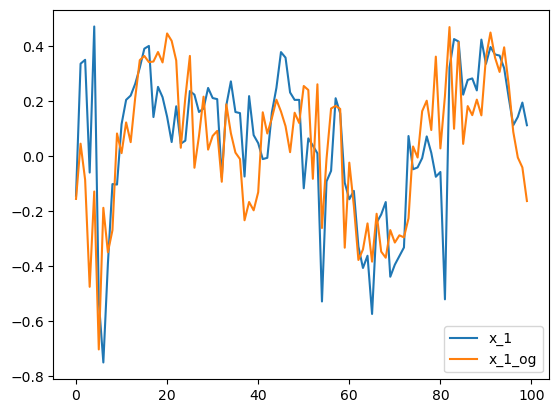

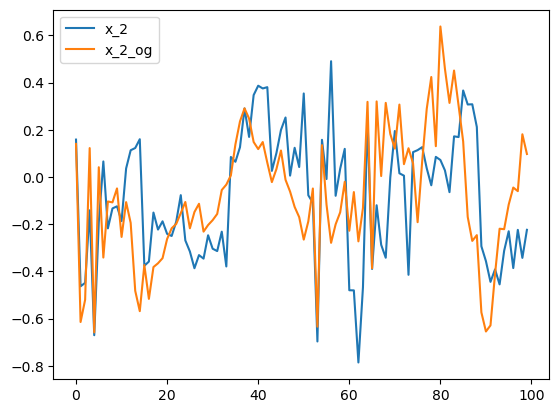

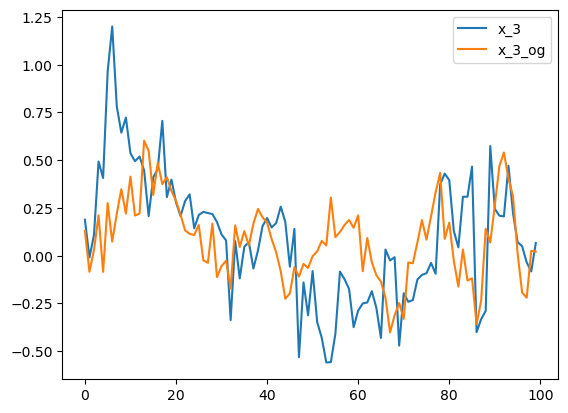

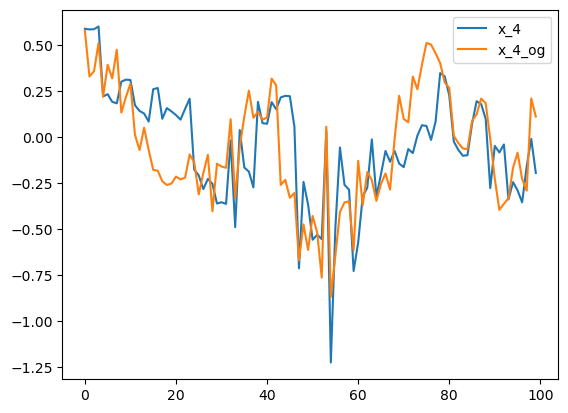

In [31]:
# Plot the results by comparing the states and states_og in each dimension
states_og = states
states = np.array(track_state)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(states[:,0],label='x_1')
plt.plot(states_og[:,0],label='x_1_og')
plt.legend()
plt.figure()
plt.plot(states[:,1],label='x_2')
plt.plot(states_og[:,1],label='x_2_og')
plt.legend()
plt.figure()
plt.plot(states[:,2],label='x_3')
plt.plot(states_og[:,2],label='x_3_og')
plt.legend()
plt.figure()
plt.plot(states[:,3],label='x_4')
plt.plot(states_og[:,3],label='x_4_og')
plt.legend()
plt.show()